In [1]:
import numpy as np 
from sklearn.preprocessing import LabelBinarizer
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import cross_validate, cross_val_predict,  StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


In [2]:
df = pd.read_csv("dataset/dataset_completo.csv")

/home/vinny/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (84) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Tratamento do dataset, baseado nas exploracoes anteriores.

# Limpando as colunas
df.columns = df.columns.str.strip()

# Dropando colunas que nao sao interessantes para nossa deteccao
df.drop('Flow ID', axis=1, inplace=True)
df.drop('Source IP', axis=1, inplace=True)
df.drop('Destination IP', axis=1, inplace=True)
df.drop('Timestamp', axis=1, inplace=True)
df.drop('SimillarHTTP', axis=1, inplace=True)
df.drop('Source Port', axis=1, inplace=True)
df.drop('Protocol', axis=1, inplace=True)
df.drop('Flow Duration', axis=1, inplace=True)
df.drop('Destination Port', axis=1, inplace=True)

# Lidando com INF, -INF, NNAN, ...
df = df[df.notna().all(1)]
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df[df.notna().all(1)]

In [4]:
# Mostrando as classes do label, para posterior rotulacao.
df.groupby(['Label']).size()

Label
BENIGN           13623
DrDoS_DNS        24523
DrDoS_LDAP       10702
DrDoS_MSSQL      21940
DrDoS_NTP         5985
DrDoS_NetBIOS    19783
DrDoS_SNMP       25745
DrDoS_SSDP       12867
DrDoS_UDP        15461
dtype: int64

In [5]:
# Rotulando as classes, 0 = trafego normal, 1 = ataque DDoS.

df.loc[df['Label'] != "BENIGN", 'Label'] = 'DDOS'

lb = LabelBinarizer()
df['Label'] = lb.fit_transform(df['Label'].values)

df.shape

(150629, 78)

In [6]:
# Separando o dataset em 2 porções, 80%(treino) e 20%(teste) 
df_separado = shuffle(df, random_state=None).reset_index(drop=True)
particao = int(df_separado.shape[0] * 0.8)
df_80 = df_separado.loc[:particao, :]
df_20 = df_separado.loc[particao:, :]


In [7]:
# Distribuicao de amostras por classe
sns.set_theme(font_scale=1.4)
df_plot = pd.DataFrame({
    'Classe': df_80['Label'].unique(),
    'Amostras': df_80['Label'].value_counts()
})
df_plot = df_plot.replace(0, "Tráfego Normal")
df_plot = df_plot.replace(1, "Ataque DDoS")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


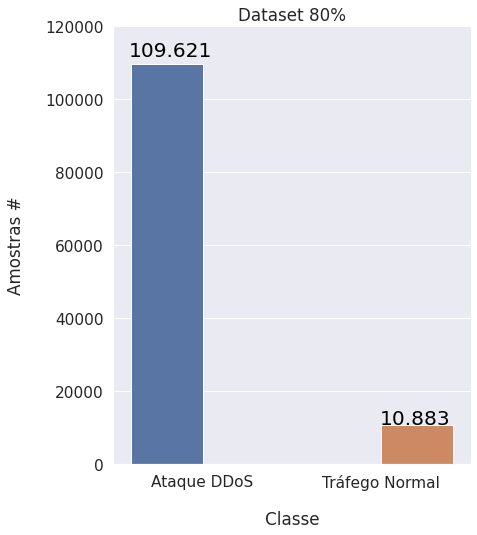

In [8]:
g =sns.catplot(data=df_plot, kind="bar", x="Classe", y="Amostras", hue="Classe", legend=True)
g.set(title ='Dataset 80%')
g.set_axis_labels("Classe", "Amostras #", labelpad=20)

g.fig.set_size_inches(8,7)
g.fig.subplots_adjust(top=0.99,right=0.86) 
ax = g.facet_axis(0,0)
ax.set(ylim=(0, 120000))
for p in ax.patches:
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{0}'.format(p.get_height()/1000), 
            color='black', 
            rotation='horizontal', 
            size='large')

In [9]:

sns.set_theme(font_scale=1.4)
df_plot_20 = pd.DataFrame({
    'Classe': df_20['Label'].unique(),
    'Amostras': df_20['Label'].value_counts()
})

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


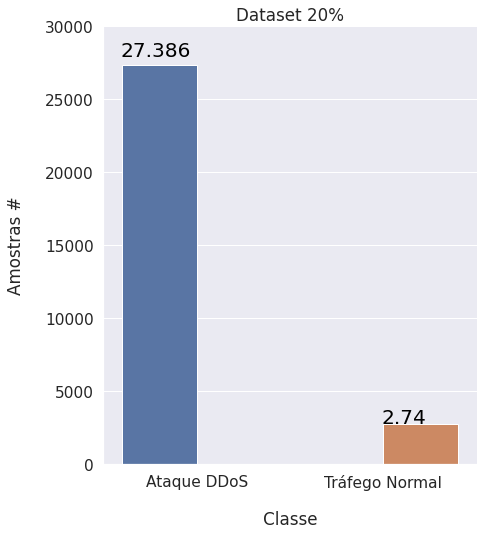

In [10]:
df_plot_20 = df_plot_20.replace(0, "Tráfego Normal")
df_plot_20 = df_plot_20.replace(1, "Ataque DDoS")
k =sns.catplot(data=df_plot_20, kind="bar", x="Classe", y="Amostras", hue="Classe", legend=True)
k.set(title ='Dataset 20%')
k.set_axis_labels("Classe", "Amostras #", labelpad=20)

k.fig.set_size_inches(8,7)
k.fig.subplots_adjust(top=0.99,right=0.86) 
ax = k.facet_axis(0,0)
ax.set(ylim=(0, 30000))
for p in ax.patches:
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{0}'.format(p.get_height()/1000), 
            color='black', 
            rotation='horizontal', 
            size='large')

# Modelos

In [11]:
# Conjunto de dados de teste e conjunto de dados de treino.
x_train = df_80.drop('Label',1)
y_train = df_80.Label
x_test = df_20.drop('Label',1)
y_test = df_20.Label
x_df_full = df_separado.drop('Label', 1)
y_df_full = df_separado.Label

## KNN

In [50]:
# Criacao do KNN
knn = KNeighborsClassifier(n_neighbors=3)

# Treinando o modelo
knn.fit(x_train, y_train)
knn.score(x_test,y_test)
# testando o modelo criado na parte de teste do dataset
result_knn = knn.predict(x_test)

In [51]:
# Precisao
precisao_knn = precision_score(y_test, result_knn)
print('Precisao: %f' % precisao_knn)

# Recall
recall_knn = recall_score(y_test, result_knn)
print('Recall: %f' % recall_knn)

# Como nosso dataset eh desbalanceado, como observado nos graficos de distrubicao das classes,
# Temos que incluir o F1Score como métrica.
# F1Score
f1score_knn = f1_score(y_test, result_knn)
print('F1Score : %f' % f1score_knn)

Precisao: 0.999487
Recall: 0.999451
F1Score : 0.999469


Obtemos uma precisão de 99%, ou seja, de todo o trafego de rede, os trafegos que o modelo previu como ataque DDoS, realmente eram ataque DDoS.

Analisando o Recall, também obtemos 99%, a métrica analisa o total do trafego de rede, tendo em conta todos os tráfegos, quanto o modelo conseguiu prever de ataque DDoS.

Então, agora observando o f1score, que resume as métricas de recall e precisão, também obtivemos 99%.

In [52]:
# Matriz de confusão
print (pd.crosstab(y_test,result_knn, rownames=['Real'], colnames=['Predito'], margins=True))

Predito     0      1    All
Real                       
0        2795     14   2809
1          15  27302  27317
All      2810  27316  30126


In [61]:
y_pred_proba = knn.predict_proba(x_test)[:,1]

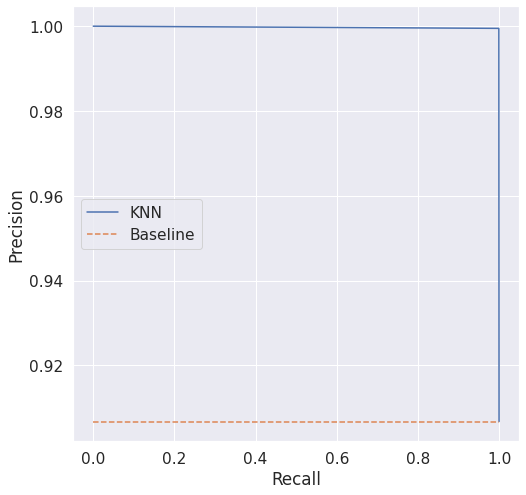

In [62]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(recall, precision, label='KNN')
baseline = len(y_test[y_test==1]) / len(y_test)
ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left');

In [17]:
# Validação Cruzada com 5 pastas (5-fold cross validation)

scoring = {'precisao' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1score' : make_scorer(f1_score)}

v_scores = cross_validate(knn, x_df_full, y_df_full, cv=5, scoring=scoring)

In [18]:
# As metricas para o k-fold cross validation
# Precisao
print('Precisao: %f' % np.average(v_scores['test_precisao']))

# Recall
print('Recall: %f' %  np.average(v_scores['test_recall']))

# Como nosso dataset eh desbalanceado, como observado nos graficos de distrubicao das classes,
# Temos que incluir o F1Score como métrica.
# F1Score
print('F1Score : %f' % np.average(v_scores['test_f1score']))

Precisao: 0.999285
Recall: 0.999489
F1Score : 0.999387


In [48]:
# Agora definindo um N de vizinhos conforme testes realizados.
n_max = 30
scores = {}
total_scores = []

for i in range(1,n_max):
    knn_teste = KNeighborsClassifier(n_neighbors=i)
    knn_teste.fit(x_train, y_train)
    knn_teste_result = knn_teste.predict(x_test)
    scores[i] = accuracy_score(y_test, knn_teste_result)
    total_scores.append(accuracy_score(y_test, knn_teste_result))

Text(0, 0.5, 'Acurácia do teste')

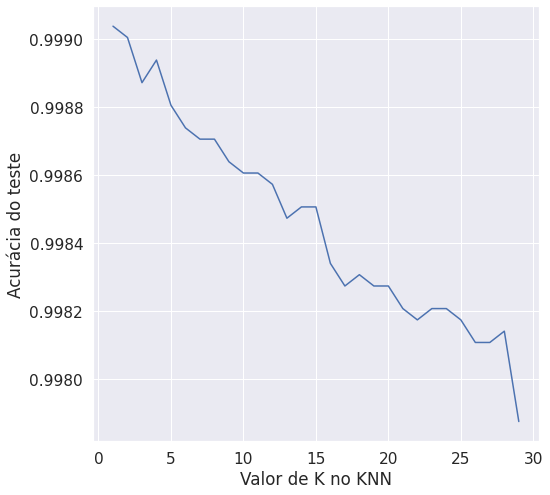

In [49]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(range(1, n_max), total_scores, label='Teste N KNN')
baseline = len(y_test[y_test==1]) / len(y_test)
ax.set_xlabel('Valor de K no KNN')
ax.set_ylabel('Acurácia do teste')

In [91]:
# Definindo grid params para a escolha das melhores configuracoes do algoritmo KNN
# Utilizando n_neightsbors proveninete da analise e grafico acima.
grid_params = {
    'n_neighbors' : [1,3],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}

In [92]:
# Executando o grid search com os parametros definidos
# Utilizando 5 k-fold cross validation.
gs = GridSearchCV(
     KNeighborsClassifier(),
     grid_params,
     verbose=0,
     cv=5,
     n_jobs = -1
)

In [93]:
gs_result = gs.fit(x_train, y_train)

In [94]:
# Mostrando os melhores parametros para nosso modelo.
gs_result.best_params_

{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}

###  Incluindo os novos parametros no teste e verificando o resultado.

Precisao: 0.999561
Recall: 0.999487
F1Score : 0.999524
Predito     0      1    All
Real                       
0        2797     12   2809
1          14  27303  27317
All      2811  27315  30126
Precisao: 0.999438
Recall: 0.999540
F1Score : 0.999489


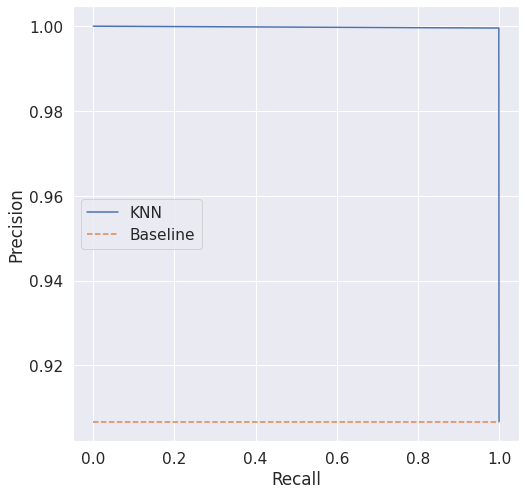

In [96]:
# Relizando o procedimento de testes novamente, dessa vez com os novos parametros otimizados.
# Criacao do KNN
knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan', weights='uniform')

# Treinando o modelo
knn.fit(x_train, y_train)
knn.score(x_test,y_test)
# testando o modelo criado na parte de teste do dataset
result_knn = knn.predict(x_test)

# Precisao
precisao_knn = precision_score(y_test, result_knn)
print('Precisao: %f' % precisao_knn)

# Recall
recall_knn = recall_score(y_test, result_knn)
print('Recall: %f' % recall_knn)

# Como nosso dataset eh desbalanceado, como observado nos graficos de distrubicao das classes,
# Temos que incluir o F1Score como métrica.
# F1Score
f1score_knn = f1_score(y_test, result_knn)
print('F1Score : %f' % f1score_knn)

# Matriz de confusão
print (pd.crosstab(y_test,result_knn, rownames=['Real'], colnames=['Predito'], margins=True))

y_pred_proba = knn.predict_proba(x_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(recall, precision, label='KNN')
baseline = len(y_test[y_test==1]) / len(y_test)
ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left');

# Validação Cruzada com 5 pastas (5-fold cross validation)

scoring = {'precisao' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1score' : make_scorer(f1_score)}

v_scores = cross_validate(knn, x_df_full, y_df_full, cv=5, scoring=scoring)

# As metricas para o k-fold cross validation
# Precisao
print('Precisao: %f' % np.average(v_scores['test_precisao']))

# Recall
print('Recall: %f' %  np.average(v_scores['test_recall']))

# Como nosso dataset eh desbalanceado, como observado nos graficos de distrubicao das classes,
# Temos que incluir o F1Score como métrica.
# F1Score
print('F1Score : %f' % np.average(v_scores['test_f1score']))

## Random Forest

In [33]:
# Criacao do Random Forest 
clf=RandomForestClassifier(n_jobs=-1)

#Treinando o Modelo
clf.fit(x_train,y_train)

# testando o modelo criado na parte de teste do dataset
resultado_rf=clf.predict(x_test)

In [34]:
# Precisao
precisao_rf = precision_score(y_test, resultado_rf)
print('Precisao: %f' % precisao_rf)

# Recall
recall_rf = recall_score(y_test, resultado_rf)
print('Recall: %f' % recall_rf)

# Como nosso dataset eh desbalanceado, como observado nos graficos de distrubicao das classes,
# Temos que incluir o F1Score como métrica.
# F1Score
f1score_rf = f1_score(y_test, resultado_rf)
print('F1Score : %f' % f1score_rf)

Precisao: 0.999927
Recall: 0.999817
F1Score : 0.999872


In [21]:
# Matriz de confusão
print (pd.crosstab(y_test,resultado_rf, rownames=['Real'], colnames=['Predito'], margins=True))

Predito     0      1    All
Real                       
0        2806      3   2809
1           5  27312  27317
All      2811  27315  30126


In [35]:
y_pred_rf = clf.predict_proba(x_test)[:,1]

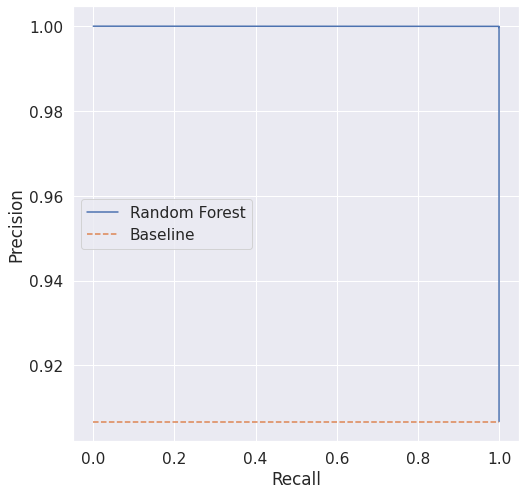

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(recall, precision, label='Random Forest')
baseline = len(y_test[y_test==1]) / len(y_test)
ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left');

In [37]:
# Validação Cruzada com 5 pastas (5-fold cross validation)

v_scores_rf = cross_validate(clf, x_df_full, y_df_full, cv=5, scoring=scoring)

In [38]:
# As metricas para o k-fold cross validation
# Precisao
print('Precisao: %f' % np.average(v_scores_rf['test_precisao']))

# Recall
print('Recall: %f' %  np.average(v_scores_rf['test_recall']))

# Como nosso dataset eh desbalanceado, como observado nos graficos de distrubicao das classes,
# Temos que incluir o F1Score como métrica.
# F1Score
print('F1Score : %f' % np.average(v_scores_rf['test_f1score']))

Precisao: 0.999927
Recall: 0.999796
F1Score : 0.999861


###  Incluindo os novos parametros no teste e verificando o resultado.

Text(0, 0.5, 'Acurácia do teste')

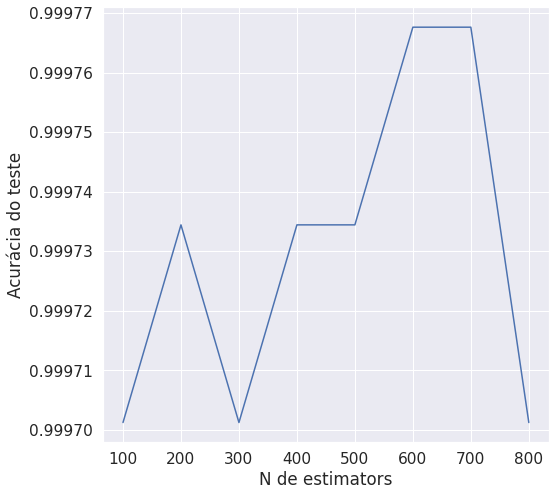

In [101]:
# Agora definindo um N de estimadores conforme testes realizados.
n_estimators = [100, 200, 300, 400, 500, 600, 700, 800]
scores_clf = {}
total_scores_clf = []

for i in n_estimators:
    clf_teste = RandomForestClassifier(n_jobs=-1, n_estimators = i)
    clf_teste.fit(x_train, y_train)
    clf_teste_result = clf_teste.predict(x_test)
    scores_clf[i] = accuracy_score(y_test, clf_teste_result)
    total_scores_clf.append(accuracy_score(y_test, clf_teste_result))
    
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(n_estimators, total_scores_clf, label='Teste Estimators Random Forest')
baseline = len(y_test[y_test==1]) / len(y_test)
ax.set_xlabel('N de estimators')
ax.set_ylabel('Acurácia do teste')

In [107]:
# Definindo grid params para a escolha das melhores configuracoes do algoritmo Random Forest
grid_params = {
    'n_estimators' : [200, 650],
    'min_samples_split': [2, 3, 5], 
    'max_depth': ['none', 5, 15, 25],
    'max_features': [20,28, 50]
}

In [108]:
# Executando o grid search com os parametros definidos
# Utilizando 5 k-fold cross validation.
gs = GridSearchCV(
     RandomForestClassifier(),
     grid_params,
     verbose=1,
     cv=5,
     n_jobs = -1
)

In [109]:
gs_result = gs.fit(x_train, y_train)
# Mostrando os melhores parametros para nosso modelo.
gs_result.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 76.4min finished


{'max_depth': 25,
 'max_features': 50,
 'min_samples_split': 3,
 'n_estimators': 200}

In [120]:
# Definindo grid params para a escolha das melhores configuracoes do algoritmo Random Forest
grid_params2 = {
    'n_estimators' : [200,650],
    'min_samples_split': [3], 
    'max_depth': [25],
    'max_features': [50]
}
gs2 = GridSearchCV(
     RandomForestClassifier(),
     grid_params2,
     verbose=1,
     cv=5,
     n_jobs = -1
)
gs_result2 = gs2.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  3.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.3min finished


In [121]:
# Mostrando os melhores parametros para nosso modelo.
gs_result2.best_params_

{'max_depth': 25,
 'max_features': 50,
 'min_samples_split': 3,
 'n_estimators': 200}

Precisao: 0.999963
Recall: 0.999817
F1Score : 0.999890
Predito     0      1    All
Real                       
0        2808      1   2809
1           5  27312  27317
All      2813  27313  30126
Precisao: 0.999934
Recall: 0.999796
F1Score : 0.999865


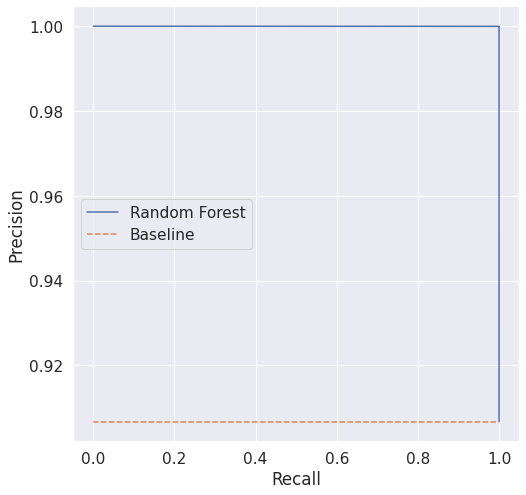

In [122]:
# Criacao do Random Forest 
clf=RandomForestClassifier(n_jobs=-1, n_estimators=200, min_samples_split=3, max_depth=25, max_features=50)

#Treinando o Modelo
clf.fit(x_train,y_train)

# testando o modelo criado na parte de teste do dataset
resultado_rf=clf.predict(x_test)

# Precisao
precisao_rf = precision_score(y_test, resultado_rf)
print('Precisao: %f' % precisao_rf)

# Recall
recall_rf = recall_score(y_test, resultado_rf)
print('Recall: %f' % recall_rf)

# Como nosso dataset eh desbalanceado, como observado nos graficos de distrubicao das classes,
# Temos que incluir o F1Score como métrica.
# F1Score
f1score_rf = f1_score(y_test, resultado_rf)
print('F1Score : %f' % f1score_rf)

# Matriz de confusão
print (pd.crosstab(y_test,resultado_rf, rownames=['Real'], colnames=['Predito'], margins=True))

y_pred_rf = clf.predict_proba(x_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(recall, precision, label='Random Forest')
baseline = len(y_test[y_test==1]) / len(y_test)
ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left');

# Validação Cruzada com 5 pastas (5-fold cross validation)

v_scores_rf = cross_validate(clf, x_df_full, y_df_full, cv=5, scoring=scoring)

# As metricas para o k-fold cross validation
# Precisao
print('Precisao: %f' % np.average(v_scores_rf['test_precisao']))

# Recall
print('Recall: %f' %  np.average(v_scores_rf['test_recall']))

# Como nosso dataset eh desbalanceado, como observado nos graficos de distrubicao das classes,
# Temos que incluir o F1Score como métrica.
# F1Score
print('F1Score : %f' % np.average(v_scores_rf['test_f1score']))

## MLP - Multi-layer Perceptron

In [39]:
# Criacao do MLP
mlp = MLPClassifier()  

#Treinando o Modelo
mlp.fit(x_train,y_train)

# testando o modelo criado na parte de teste do dataset
resultado_mlp=mlp.predict(x_test)

In [40]:
# Precisao
precisao_mlp = precision_score(y_test, resultado_mlp)
print('Precisao: %f' % precisao_mlp)

# Recall
recall_mlp = recall_score(y_test, resultado_mlp)
print('Recall: %f' % recall_mlp)

# Como nosso dataset eh desbalanceado, como observado nos graficos de distrubicao das classes,
# Temos que incluir o F1Score como métrica.
# F1Score
f1score_mlp = f1_score(y_test, resultado_mlp)
print('F1Score : %f' % f1score_mlp)

Precisao: 0.987557
Recall: 0.999414
F1Score : 0.993450


In [41]:
# Matriz de confusão
print (pd.crosstab(y_test,resultado_mlp, rownames=['Real'], colnames=['Predito'], margins=True))

Predito     0      1    All
Real                       
0        2465    344   2809
1          16  27301  27317
All      2481  27645  30126


In [42]:
y_pred_mlp = mlp.predict_proba(x_test)[:,1]

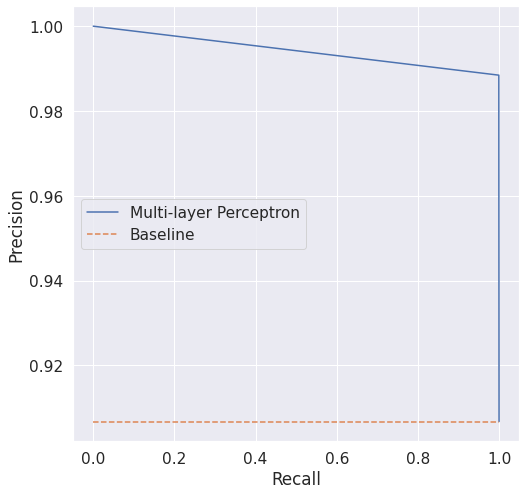

In [43]:
precision_mlp, recall_mlp, thresholds = precision_recall_curve(y_test, y_pred_mlp)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(recall_mlp, precision_mlp, label='Multi-layer Perceptron')
baseline = len(y_test[y_test==1]) / len(y_test)
ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left');

In [44]:
# Validação Cruzada com 5 pastas (5-fold cross validation)

v_scores_mlp = cross_validate(mlp, x_df_full, y_df_full, cv=5, scoring=scoring)

In [45]:
# As metricas para o k-fold cross validation
# Precisao
print('Precisao: %f' % np.average(v_scores_mlp['test_precisao']))

# Recall
print('Recall: %f' %  np.average(v_scores_mlp['test_recall']))

# Como nosso dataset eh desbalanceado, como observado nos graficos de distrubicao das classes,
# Temos que incluir o F1Score como métrica.
# F1Score
print('F1Score : %f' % np.average(v_scores_mlp['test_f1score']))

Precisao: 0.972801
Recall: 0.998482
F1Score : 0.985294


###  Incluindo os novos parametros no teste e verificando o resultado.

Text(0, 0.5, 'Acurácia do teste')

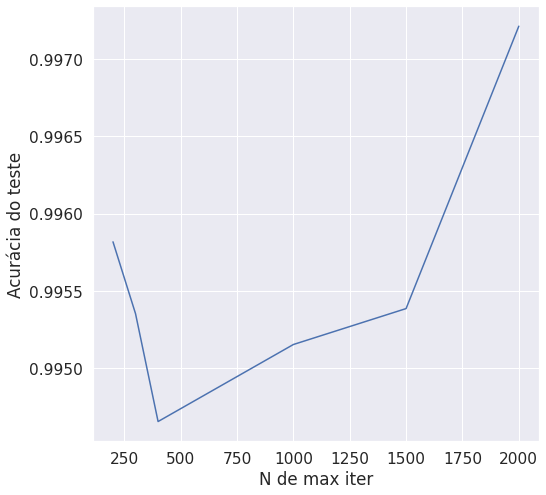

In [125]:
# Agora definindo um N de iteracoes conforme testes realizados.
max_iter = [200,300,400,1000,1500,2000]
scores_mlp = {}
total_scores_mlp = []

for i in max_iter:
    mlp_teste = MLPClassifier(max_iter = i)  
    mlp_teste.fit(x_train, y_train)
    mlp_teste_result = mlp_teste.predict(x_test)
    scores_mlp[i] = accuracy_score(y_test, mlp_teste_result)
    total_scores_mlp.append(accuracy_score(y_test, mlp_teste_result))
    
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(max_iter, total_scores_mlp, label='Teste Max iter MLP')
baseline = len(y_test[y_test==1]) / len(y_test)
ax.set_xlabel('N de max iter')
ax.set_ylabel('Acurácia do teste')

In [12]:
# Definindo grid params para a escolha das melhores configuracoes do algoritmo mlp
grid_params3 = {
    'max_iter' : [2000],
    'hidden_layer_sizes': [(10,10,10), (50,100,50), (100,)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant','adaptive'],
}
gs3 = GridSearchCV(
     MLPClassifier(),
     grid_params3,
     verbose=1,
     cv=5,
     n_jobs = -1
)
gs_result3 = gs3.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 97.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 128.0min finished


In [13]:
# Mostrando os melhores parametros para nosso modelo.
gs_result3.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'max_iter': 2000,
 'solver': 'adam'}

Precisao: 0.992061
Recall: 0.999306
F1Score : 0.995671
Predito     0      1    All
Real                       
0        2521    219   2740
1          19  27367  27386
All      2540  27586  30126
Precisao: 0.992133
Recall: 0.998256
F1Score : 0.995169


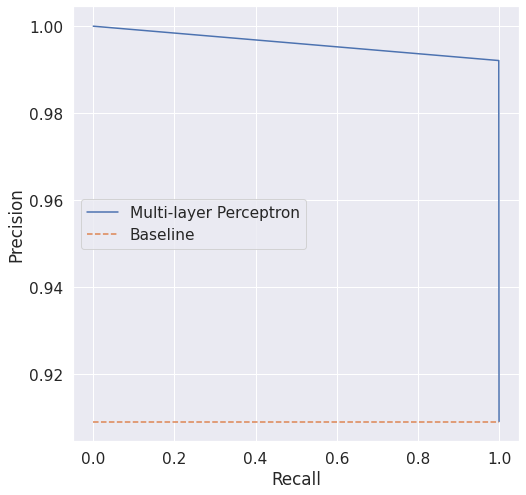

In [16]:
# Criacao do MLP
mlp = MLPClassifier(max_iter=2000, solver='adam', hidden_layer_sizes=(100,),activation='relu',alpha=0.0001,learning_rate='constant')  

#Treinando o Modelo
mlp.fit(x_train,y_train)

# testando o modelo criado na parte de teste do dataset
resultado_mlp=mlp.predict(x_test)

# Precisao
precisao_mlp = precision_score(y_test, resultado_mlp)
print('Precisao: %f' % precisao_mlp)

# Recall
recall_mlp = recall_score(y_test, resultado_mlp)
print('Recall: %f' % recall_mlp)

# Como nosso dataset eh desbalanceado, como observado nos graficos de distrubicao das classes,
# Temos que incluir o F1Score como métrica.
# F1Score
f1score_mlp = f1_score(y_test, resultado_mlp)
print('F1Score : %f' % f1score_mlp)

# Matriz de confusão
print (pd.crosstab(y_test,resultado_mlp, rownames=['Real'], colnames=['Predito'], margins=True))

y_pred_mlp = mlp.predict_proba(x_test)[:,1]

precision_mlp, recall_mlp, thresholds = precision_recall_curve(y_test, y_pred_mlp)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(recall_mlp, precision_mlp, label='Multi-layer Perceptron')
baseline = len(y_test[y_test==1]) / len(y_test)
ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left');

scoring = {'precisao' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1score' : make_scorer(f1_score)}

# Validação Cruzada com 5 pastas (5-fold cross validation)

v_scores_mlp = cross_validate(mlp, x_df_full, y_df_full, cv=5, scoring=scoring)

# As metricas para o k-fold cross validation
# Precisao
print('Precisao: %f' % np.average(v_scores_mlp['test_precisao']))

# Recall
print('Recall: %f' %  np.average(v_scores_mlp['test_recall']))

# Como nosso dataset eh desbalanceado, como observado nos graficos de distrubicao das classes,
# Temos que incluir o F1Score como métrica.
# F1Score
print('F1Score : %f' % np.average(v_scores_mlp['test_f1score']))